# population-inference
notebook for running vectorised inference over a population of hares or emus

In [12]:
#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
import os
##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca import emulator
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_nice
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_simpleslice
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_slice
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_walk
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_surface


os.environ["CUDA_VISIBLE_DEVICES"]="0"

physical_devices = tf.config.list_physical_devices("GPU") 

tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

## import neural network

In [13]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


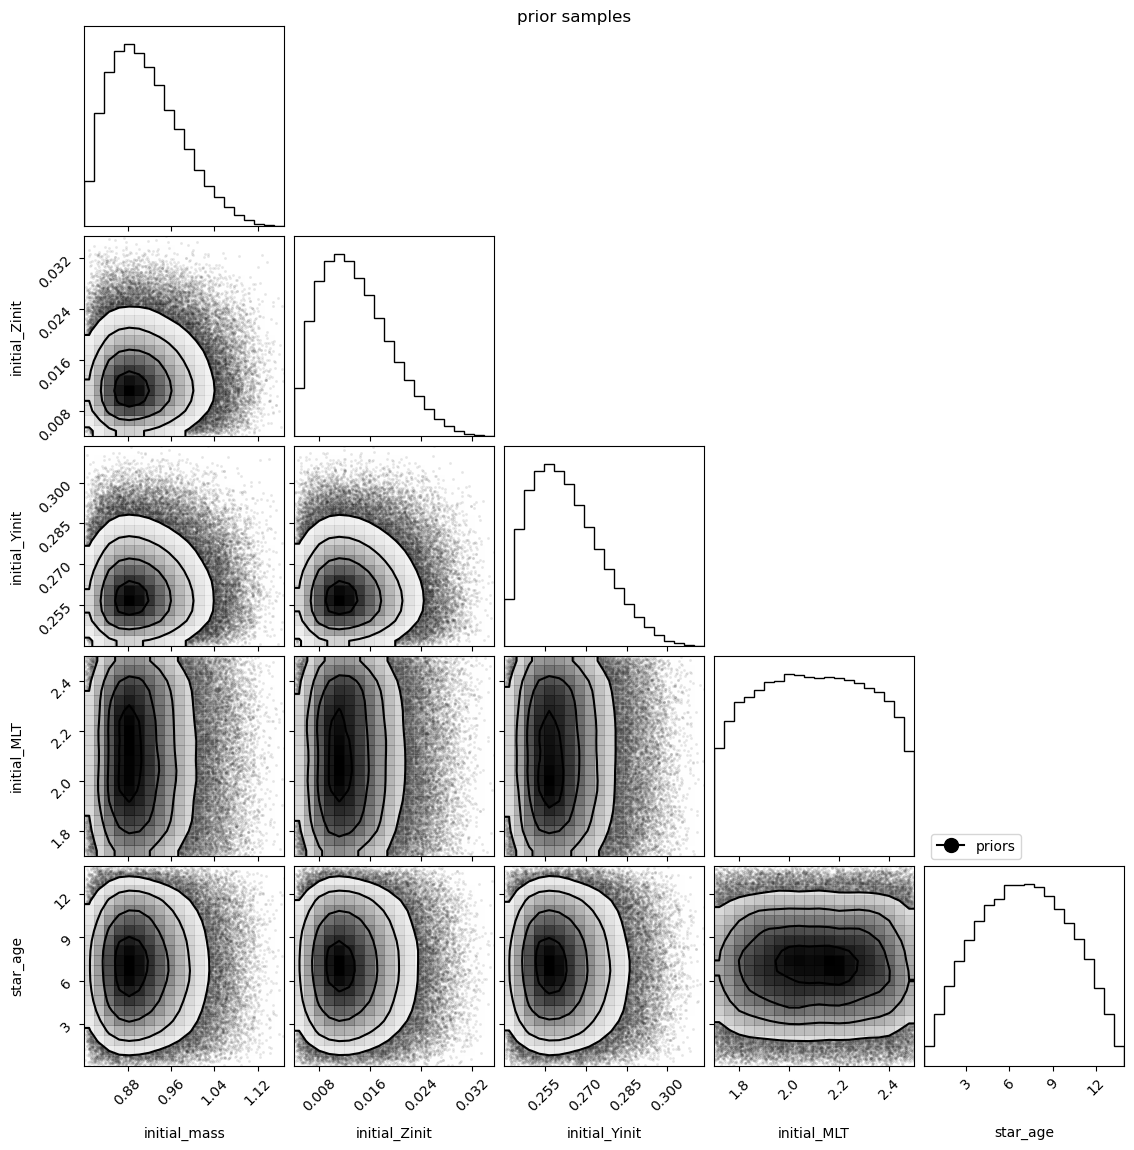

In [3]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=2, b=2)


priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior]

size = 100000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

In [ ]:
%%time

with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

ndraw_min=2**16
ndraw_max=2**16

for obs_idx in range(5):
    for hare_idx in range(100):
        path = f'form/hare{hare_idx}/obs{obs_idx}/'
        hare_observed = pd.read_json(path+f'obs{obs_idx}.json')
        hare_uncs = pd.read_json(path+'uncs.json')
        hare_uncs_array = hare_uncs.values[0]
    
        n_min = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[0].replace('nu_0_',''))
        n_max = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[-1].replace('nu_0_',''))
    
        sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
        sigma_nn_mask[:3] = True
        sigma_nn_mask[n_min-3:n_max-2] = True
    
        sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]
    
        sigma_obs = (hare_uncs_array*hare_uncs_array)*(np.identity(len(hare_uncs_array)))
    
        sigma = sigma_nn_cropped + sigma_obs
    
        sigma_inv = np.linalg.inv(sigma)
    
        _, log_sigma_det = np.linalg.slogdet(sigma)
        
        outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
        
        sampler = ultra_ns_vector_simpleslice(priors=priors, observed_vals=hare_observed[outputs].values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, n_min=n_min, n_max=n_max, logl_scale=1)
        results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=400, frac_remain=.001)
        with open(path+'/samples.pkl', 'wb') as fp:
            pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
        sampler.cleanup()
        del results

In [ ]:
%%time

with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

ndraw_min=2**16
ndraw_max=2**16

for obs_idx in range(5):
    for hare_idx in range(100):
        path = f'surf_form/hare{hare_idx}/obs{obs_idx}/'
        hare_observed = pd.read_json(path+f'obs{obs_idx}.json')
        hare_uncs = pd.read_json(path+'uncs.json')
        hare_uncs_array = hare_uncs.values[0]
    
        n_min = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[0].replace('nu_0_',''))
        n_max = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[-1].replace('nu_0_',''))
    
        sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
        sigma_nn_mask[:3] = True
        sigma_nn_mask[n_min-3:n_max-2] = True
    
        sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]
    
        sigma_obs = (hare_uncs_array*hare_uncs_array)*(np.identity(len(hare_uncs_array)))
    
        sigma = sigma_nn_cropped + sigma_obs
    
        sigma_inv = np.linalg.inv(sigma)
    
        _, log_sigma_det = np.linalg.slogdet(sigma)
        
        outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
        
        sampler = ultra_ns_vector_surface(priors=priors, observed_vals=hare_observed[outputs].values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, nu_max = 3050, n_min=n_min, n_max=n_max, logl_scale=1)
        results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=400, frac_remain=.1)
        with open(path+'/samples.pkl', 'wb') as fp:
            pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
        sampler.cleanup()
        del results

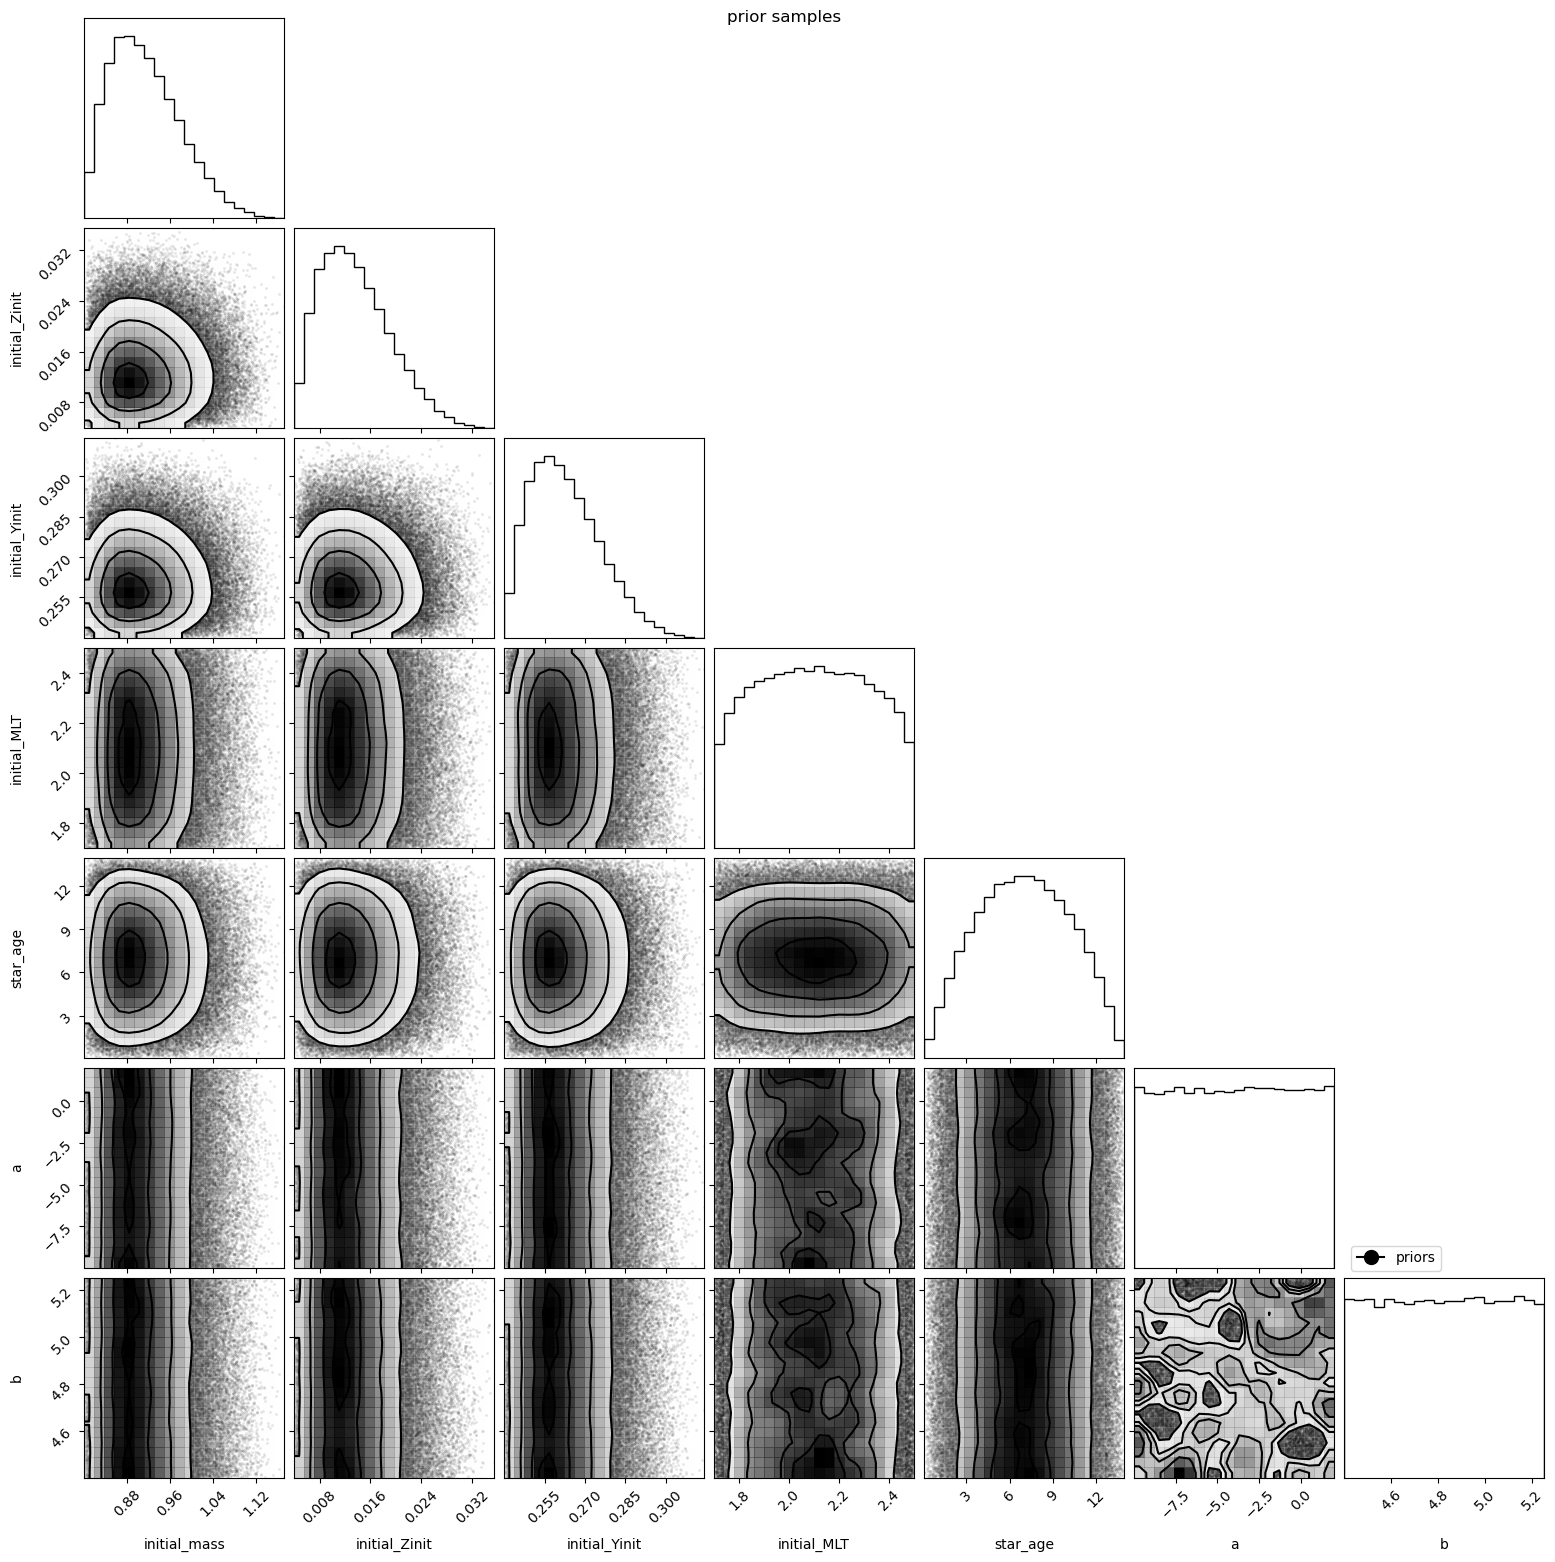

In [14]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=2, b=2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)



priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 100000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

In [16]:
%%time

with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

ndraw_min=2**16
ndraw_max=2**20

for obs_idx in range(1):
    for hare_idx in range(1):
        path = f'surf_form/hare{hare_idx}/obs{obs_idx}/'
        hare_observed = pd.read_json(path+f'obs{obs_idx}.json')
        hare_uncs = pd.read_json(path+'uncs.json')
        hare_uncs_array = hare_uncs.values[0]
    
        n_min = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[0].replace('nu_0_',''))
        n_max = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[-1].replace('nu_0_',''))
    
        sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
        sigma_nn_mask[:3] = True
        sigma_nn_mask[n_min-3:n_max-2] = True
    
        sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]
    
        sigma_obs = (hare_uncs_array*hare_uncs_array)*(np.identity(len(hare_uncs_array)))
    
        sigma = sigma_nn_cropped + sigma_obs
    
        sigma_inv = np.linalg.inv(sigma)
    
        _, log_sigma_det = np.linalg.slogdet(sigma)
        
        outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
        
        sampler = ultra_ns_vector_surface(priors=priors, observed_vals=hare_observed[outputs].values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, nu_max = 3050, n_min=n_min, n_max=n_max, logl_scale=1)
        results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=400, frac_remain=.1)
        with open(path+'/samples.pkl', 'wb') as fp:
            pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
        sampler.cleanup()
        del results

[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1811: UserWarning: Sampling from region seems inefficient (0/65536 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1e+01   [-13.2081..-13.2078]*| it/evals=6436/1449992 eff=0.2608% N=400 
[ultranest] Likelihood function evaluations: 1449992
[ultranest]   logZ = -26.77 +- 0.1406
[ultranest] Effective samples strategy satisfied (ESS = 2054.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.14 tail:0.10 total:0.17 required:<0.50
[ultranest] done iterating.
CPU times: user 11min 22s, sys: 29.9 s, total: 11min 52s
Wall time: 11min 49s


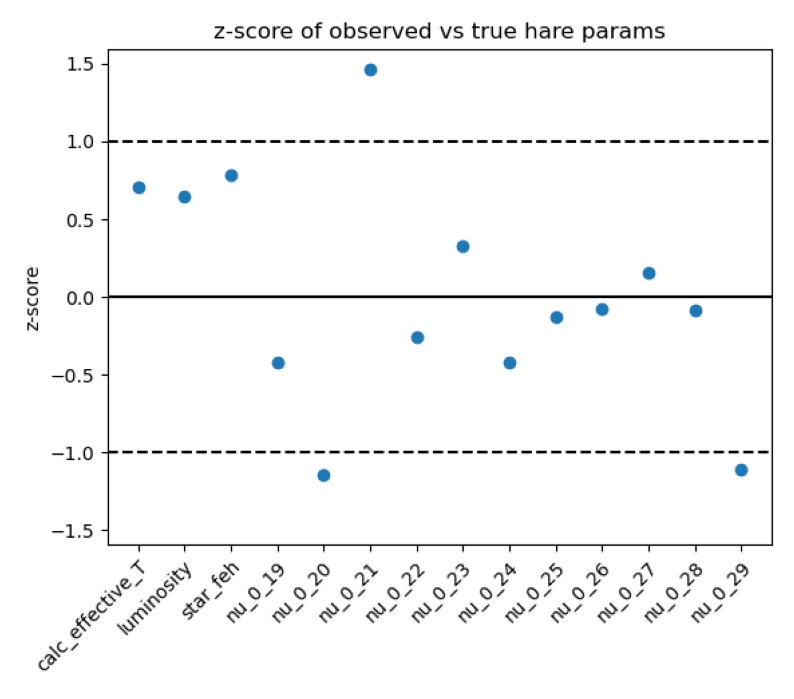

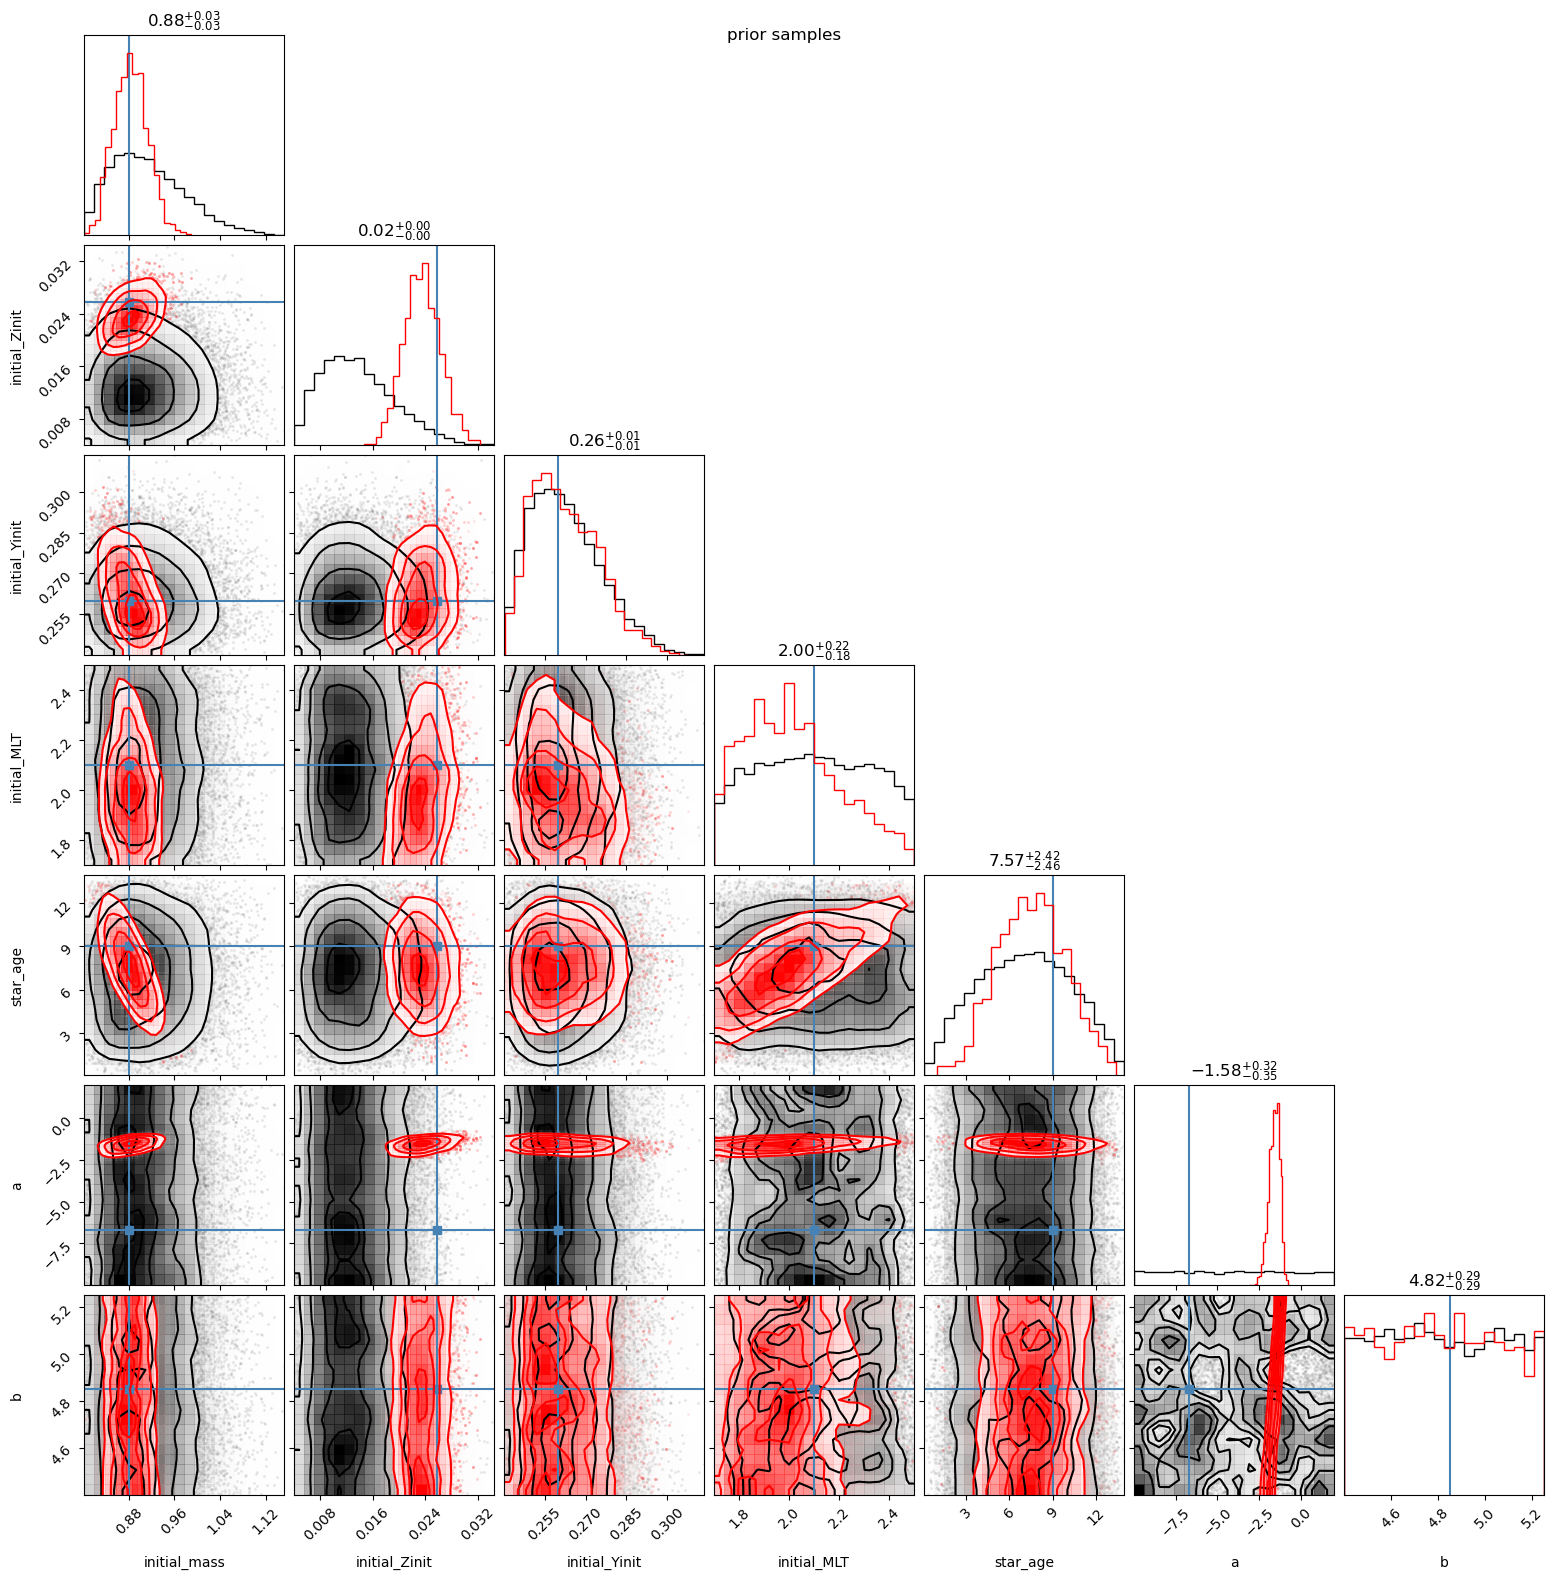

In [17]:
def inspect_hare(hare_idx, obs_idx):
    path = f'surf_form/hare{hare_idx}'
    image = plt.imread(path+f'/obs{obs_idx}/zscore_plot.png')

    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(image)
    ax.axis('off')

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
    
    mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)
    
    Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)
    
    Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)
    
    MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)
    
    age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=2, b=2)
    
    a_prior = prior_funcs.custom_uniform_prior(-10, 2)
    
    b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)
    
    
    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

    hare_df = pd.read_json(path+f'/obs{obs_idx}/obs{obs_idx}.json')[labels]

    
    with open(path+f'/obs{obs_idx}/samples.pkl', 'rb') as fp:
         samples = pickle.load(fp)
    
    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, truths = hare_df.values[0], color=corner_color, hist_kwargs={'density':True}, smooth=True);
    corner.corner(samples['samples'], fig=figure, color='red',hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.suptitle('prior samples')
    plt.show()

    
inspect_hare(0,0)